In [30]:
!python setup.py install

running install
/Users/yann/.pyenv/versions/3.10.6/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/Users/yann/.pyenv/versions/3.10.6/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing BlackBoxDecoder.egg-info/PKG-INFO
writing dependency_links to BlackBoxDecoder.egg-info/dependency_links.txt
writing top-level names to BlackBoxDecoder.egg-info/top_level.txt
reading manifest file 'BlackBoxDecoder.egg-info/SOURCES.txt'
adding license file 'LICENSE'
writing manifest file 'BlackBoxDecoder.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-12.4-x86_64/egg
running install_lib
running build_ext
building 'BlackBoxDecoder' extension
clang -Wno-

15 warnings generated.
clang -bundle -undefined dynamic_lookup -L/usr/local/opt/readline/lib -L/usr/local/opt/readline/lib -L/Users/yann/.pyenv/versions/3.10.6/lib -L/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/lib -L/usr/local/opt/readline/lib -L/usr/local/opt/readline/lib -L/Users/yann/.pyenv/versions/3.10.6/lib -L/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/lib build/temp.macosx-12.4-x86_64-cpython-310/src/battery.o build/temp.macosx-12.4-x86_64-cpython-310/src/blackbox_fielddefs.o build/temp.macosx-12.4-x86_64-cpython-310/src/decoders.o build/temp.macosx-12.4-x86_64-cpython-310/src/gpxwriter.o build/temp.macosx-12.4-x86_64-cpython-310/src/imu.o build/temp.macosx-12.4-x86_64-cpython-310/src/parser.o build/temp.macosx-12.4-x86_64-cpython-310/src/platform.o build/temp.macosx-12.4-x86_64-cpython-310/src/stats.o build/temp.macosx-12.4-x86_64-cpython-310/src/stream.o build/temp.mac

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy import signal

import BlackBoxDecoder

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14,10)

In [4]:
data = BlackBoxDecoder.decode("btfl_001.bbl")
flights = len(data)
df = []
for i in range(flights):
    df.append(pd.DataFrame(data[i]))

(0.0, 146215.65)

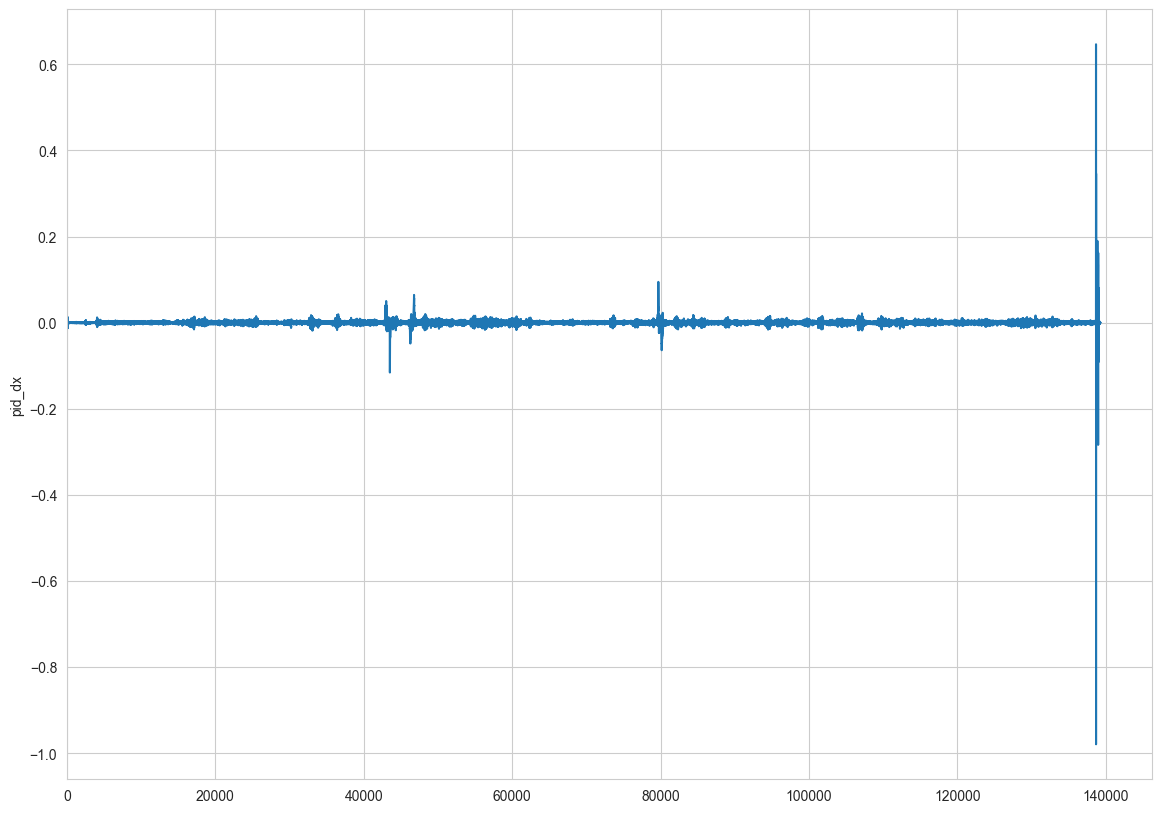

In [3]:
sns.lineplot(data=df[0]['pid_dx'])
plt.xlim(0)

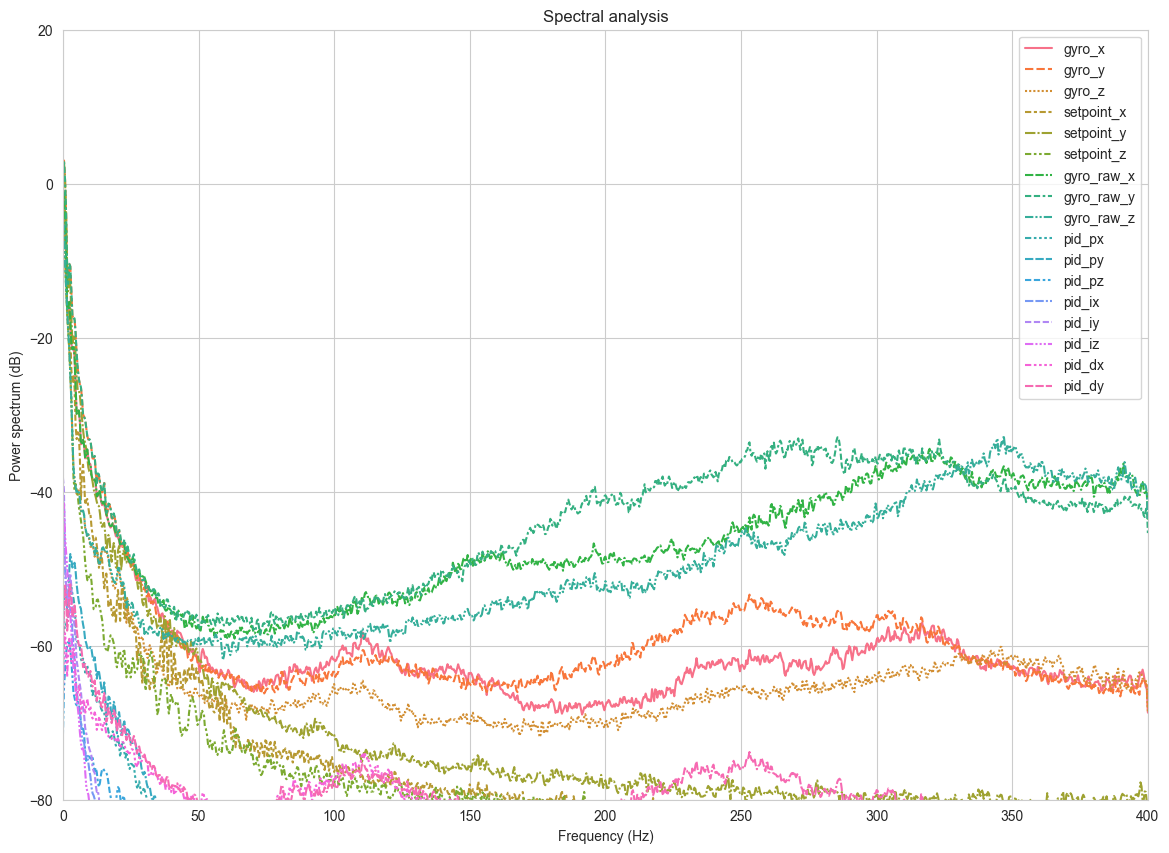

In [5]:
def compute_noise(df, fields = ['gx', 'gy', 'gz'], FS=800, segment_size=2048):
    def fft_np_array(y):
        f, Pxx = signal.welch(y,                        # signal
                              fs=FS,                    # sample rate
                              nperseg=segment_size,     # segment size
                              window='hann',            # window type to use
                              nfft=segment_size,        # num. of samples in FFT
                              detrend=False,            # remove DC part
                              scaling='spectrum',       # return power spectrum [V^2]
                              noverlap=segment_size/2)  # overlap between segments
        # set 0 dB to energy of sine wave with maximum amplitude
        #ref = (1/np.sqrt(2)**2)   # simply 0.5 ;)
        ref = 1
        p = 10 * np.log10(Pxx/ref)
        return f, p

    data = {}
    for field in fields:
        f, p = fft_np_array(df[field].to_numpy())
        data[field] = p

    return pd.DataFrame(data, f)

def plot_noise(data, FS=800):
    sns.lineplot(data=data)
    plt.ylim([-80, 20])
    plt.xlim([0, FS//2])
    plt.ylabel('Power spectrum (dB)')
    plt.xlabel('Frequency (Hz)')
    plt.title("Spectral analysis")

for i in [0]:
    noise = compute_noise(df[i], df[i].columns.values)
    #plot_noise(noise[['pid_dx', 'gyro_x', 'gyro_raw_x']])
    plot_noise(noise)


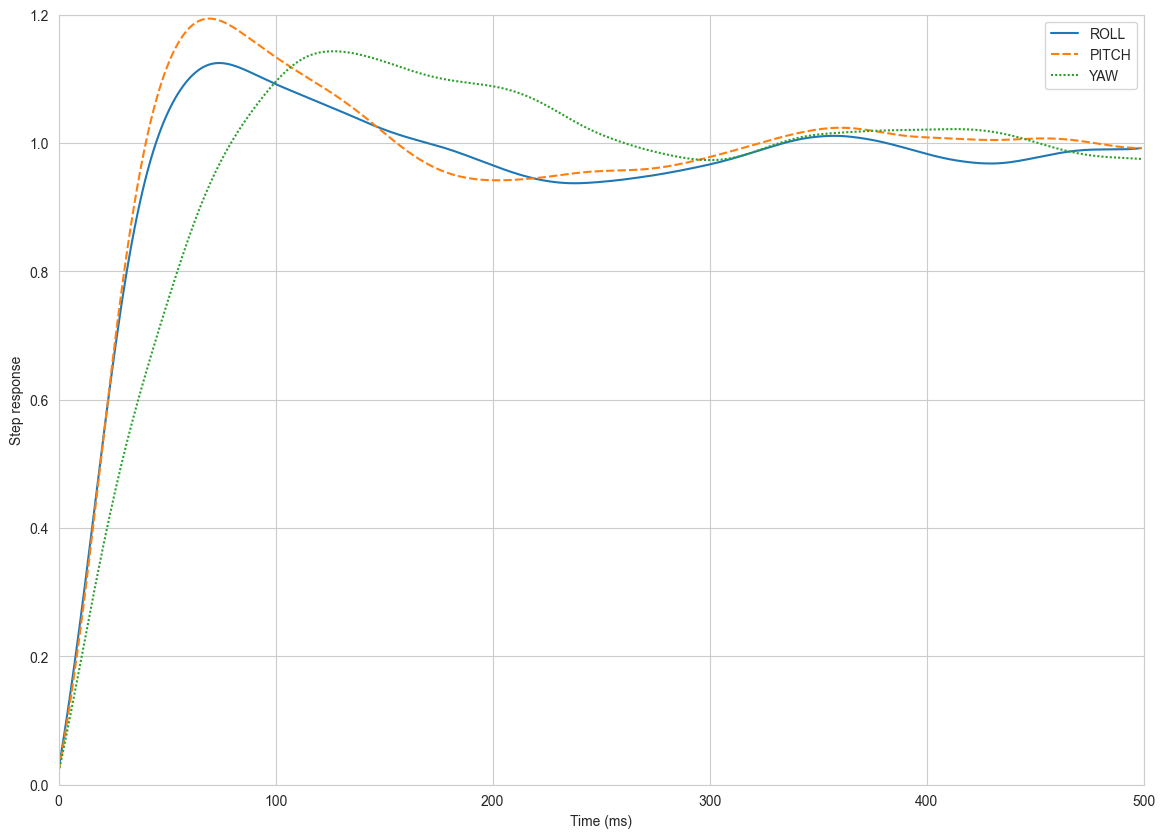

In [16]:
def compute_step_response(df):
    def PTstepcalc(SP, GY, lograte):
        minInput = 0.34 # rad/s
        segment_length = int(lograte*2000) # 2 sec segments
        wnd = int(lograte*1000 * .5) # 500ms step response function, length will depend on lograte  
        StepRespDuration_ms = 500 # max dur of step resp in ms for plotting
        t = np.arange(0, StepRespDuration_ms, 1/lograte)# time in ms 

        fileDurSec = len(SP) / (lograte*1000)
        subsampleFactor = 10

        segment_vector = np.arange(1, len(SP), round(segment_length/subsampleFactor))
        NSegs = len(segment_vector)

        stepresponse = []
        if NSegs > 0:
            SPseg = []
            #SPseg = np.array()
            GYseg = []
            j = 0
            for i in range(NSegs):
                if np.max(np.abs(SP[segment_vector[i]:segment_vector[i]+segment_length])) >= minInput:
                    j=j+1
                    SPseg.append(SP[segment_vector[i]:segment_vector[i]+segment_length])  
                    GYseg.append(GY[segment_vector[i]:segment_vector[i]+segment_length]) 

            #print("SPseg", SPseg)
            SPseg = np.array(SPseg, dtype=object)
            GYseg = np.array(GYseg, dtype=object)

            # padLength = 0# 2^nextpow2(length(SPseg(i,:)));
            j=0 
            if len(SPseg) > 0:
                for i in range(len(SPseg)):
                    a = GYseg[i]*np.hanning(len(GYseg[i]))                
                    b = SPseg[i]*np.hanning(len(SPseg[i]))
                    # a = np.concatenate([np.zeros(padLength), a, np.zeros(padLength)])
                    # b = np.concatenate([np.zeros(padLength), b, np.zeros(padLength)])
                    a = np.fft.fft(a)
                    b = np.fft.fft(b)
                    G = a / len(a)
                    H = b / len(b) 
                    Hcon = np.conj(H)  

                    imp = np.real(np.fft.ifft((G * Hcon) / (H * Hcon + 0.0001 )))
                    resptmp = np.cumsum(imp) # integrate impulse resp function 

                    steadyStatePoints = resptmp[50:]
                    steadyStateMean = np.mean(steadyStatePoints)

                    resptmp = resptmp / steadyStateMean

                    if np.min(steadyStatePoints) < 0.50 or max(steadyStatePoints) > 3: # Quality control
                        continue
                    j=j+1
                    stepresponse.append(resptmp[:wnd])
                    #sns.lineplot(stepresponse[-1])
        return t, np.mean(stepresponse, axis=0) if stepresponse else None

    t, stepresponse_x = PTstepcalc(df['setpoint_x'].to_numpy(), df['gyro_x'].to_numpy(), 0.8)
    t, stepresponse_y = PTstepcalc(df['setpoint_y'].to_numpy(), df['gyro_y'].to_numpy(), 0.8)
    t, stepresponse_z = PTstepcalc(df['setpoint_z'].to_numpy(), df['gyro_z'].to_numpy(), 0.8)

    return pd.DataFrame({
        'ROLL': stepresponse_x,
        'PITCH': stepresponse_y,
        'YAW': stepresponse_z,
    }, t)

def plot_step_response(data):
    sns.lineplot(data=data)
    plt.ylim([0, 1.2])
    plt.xlim([0, 500])
    plt.ylabel('Step response')
    plt.xlabel('Time (ms)')

data_step_response = compute_step_response(df)
plot_step_response(data_step_response)